# **FASE IV: MODELADO**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sbn
from seaborn import kdeplot
from seaborn import lmplot
from seaborn import boxplot

import warnings #Advertencias
warnings.filterwarnings('ignore')

#Mostrar todas las columnas
pd.options.display.max_columns = 70
pd.options.display.max_rows = 70
#Ajuste de formato para evitar notacion científica
pd.options.display.float_format = '{:20,.5f}'.format

# Carga de parquet preprocesado
path = 'monopoly_cleaned_parquet'
monopoly = pd.read_parquet(path)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [3]:
# Librerías de Nvidia para procesamiento con GPU (en caso de que alguien tenga una GTX o RTX)
import cudf, cuml, cupy, cugraph, cuspatial, dask_cudf

## Modelos de Regresión

### Modelo de Arbol de Decisión

#### Definición variables

**Definición de variables $X$ e $Y$**

In [315]:
# Seleccion de variable dependiente
Y = pd.DataFrame(monopoly['Renta'])
Y.head()

,Renta
0,"601,932.80000"
1,"143,640.00000"
2,"929,106.00000"
3,"172,447.00000"
4,"805,250.00000"


Se selecciona la variable dependiente $Y$ **Renta**

In [316]:
# Seleccion de variables independientes
X = monopoly.drop(columns=['Renta'])
X.head()

,Subsegmento,Sexo,Region,Edad,Antiguedad,Internauta,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,target,FlgAct_sum,FlgActCN_sum,FlgActCI_sum,FlgActAN_sum,FlgActAI_sum,FlgActPAT_sum,FlgActCCPC_sum,FlgActCCOT_sum,FlgActCOL_sum,Fac_avg,Txs_avg,FacCN_avg,TxsCN_avg,FacCI_avg,TxsCI_avg,FacAN_avg,TxsAN_avg,FacAI_avg,TxsAI_avg,FacPAT_avg,TxsPAT_avg,FacCCPC_avg,TxsCCPC_avg,FacCCOT_avg,TxsCCOT_avg,FacCOL_avg,TxsCOL_avg,FacDebCom_avg,TxsDebCom_avg,FacDebAtm_avg,TxsDebAtm_avg,Col_avg,ColL1T0_avg,ColL1TE_avg,ColL2T0_avg,ColL2AC_avg,ColL2CC_avg,ColMx_avg,PagoNac_avg,PagoInt_avg,EeccNac_avg,EeccInt_avg,UsoL1_avg,UsoL2_avg,UsoLI_avg
0,160.00000,1.00000,13.00000,43.00000,130.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,3.00000,"798,000.00000","1,012,000.00000","1,210.00000",0.00000,6.00000,6.00000,0.00000,0.00000,0.00000,0.00000,4.00000,1.00000,0.00000,"32,185.25000",1.91667,"32,185.25000",1.91667,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"15,511.25000",0.66667,"6,460.75000",0.25000,0.00000,0.00000,"178,764.16667",28.91667,"99,000.00000",4.25000,"920,109.33333","15,059.41667","842,900.75000","27,449.50000",0.00000,"34,699.66667",0.00000,"29,333.33333",0.00000,"908,079.41667",0.00000,"913,045.58333","53,874.25000",0.00000
1,160.00000,0.00000,13.00000,46.00000,69.00000,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,1.00000,1.00000,"750,000.00000","150,000.00000","1,000.00000",0.00000,11.00000,10.00000,2.00000,0.00000,0.00000,0.00000,9.00000,3.00000,0.00000,"112,918.44812",3.66667,"81,006.83333",2.58333,"31,911.61478",1.08333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"62,203.66667",1.58333,"8,916.66667",0.33333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"513,504.12917","7,469.83333","309,153.41667","133,584.41667",0.00000,"17,597.25000","45,699.21250","167,416.66667",0.00000,"460,136.50000",58.90417,"428,734.83333","119,963.91667",84.50833
2,170.00000,0.00000,13.00000,45.00000,24.00000,1.00000,1.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,1.00000,1.00000,2.00000,"1,350,000.00000","200,000.00000","1,500.00000",0.00000,12.00000,12.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"148,982.41667",5.00000,"140,434.33333",4.66667,"8,548.08333",0.33333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"118,568.66667",6.75000,"741,071.75000",15.00000,"117,984.83333","117,984.83333",0.00000,0.00000,0.00000,0.00000,0.00000,"68,325.75000",0.00000,"8,510.75000",0.00000,"25,294.50000",0.00000,0.00000
3,151.00000,0.00000,13.00000,46.00000,134.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,2.00000,"1,570,800.00000","220,001.00000",0.00000,0.00000,11.00000,11.00000,0.00000,0.00000,0.00000,0.00000,9.00000,1.00000,0.00000,"34,523.83333",2.08333,"34,523.83333",2.08333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"20,909.16667",1.16667,"1,082.50000",0.08333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"340,728.08333","14,826.16667","295,497.25000","27,698.16667",0.00000,"2,706.50000",0.00000,"57,083.33333",0.00000,"341,916.83333",0.00000,"344,417.50000","31,825.25000",0.00000
4,170.00000,0.00000,13.00000,46.00000,116.00000,0.00000,1.00000,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000,1.00000,2.00000,3.00000,"2,762,000.00000",2.00000,"6,430.00000",0.00000,12.00000,12.00000,0.00000,0.00000,0.00000,0.00000,12.00000,1.00000,0.00000,"293,939.00000",8.91667,"293,939.00000",8.91667,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"228,901.25000",4.33333,"3,916.66667",0.08333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"242,907.25000","51,661.25000",17.66667,"185,000.66667",0.00000,"6,227.66667",0.00000,"291,317.16667",0.00000,"291,684.50000",0.00000,"83,849.25000","402,597.66667",0.00000


Se seleciona la variable independiente $X$ que corresponde a una matriz con todas las *features* del dataframe, exceptuando **Renta**. 

**División en sets de entrenamiento y prueba**

In [317]:
from sklearn.model_selection import train_test_split
# Se dividen las variables en conjuntos de prueba y entrenamiento
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X ,Y,test_size=0.3, random_state=455) 

Se dividen las variables $X$ e $Y$ en conjuntos de prueba y entrenamiento, se utiliza un 70% de cada variable para entrenamiento y un 30% para pruebas.

In [318]:
#Conjunto de entrenamiento
print(Xtrain.shape)
print(Ytrain.shape)

(35784, 65)
(35784, 1)


Se utilizan 35.784 registros para entrenamiento.

In [319]:
#Conjunto de prueba
print(Xtest.shape)
print(Ytest.shape)

(15337, 65)
(15337, 1)


Se utilizan 15.337 registros para pruebas.

#### **Modelo N°1**

In [320]:
from sklearn.tree import DecisionTreeRegressor

In [321]:
# Modelo 1 DTR
tree_reg_1 = DecisionTreeRegressor(random_state=123)

Se crea un árbol de desición de regresión con los hiperparámetros por defecto.

In [322]:
tree_reg_1.fit(Xtrain, Ytrain)

DecisionTreeRegressor(random_state=123)

Se ajusta el modelo a los datos de entrenamiento.

In [323]:
# Obtención de los valores de los hiperparámetros
max_depth = tree_reg_1.get_depth() # profundidad resultante 
min_samples_split = tree_reg_1.get_params()['min_samples_split']
min_samples_leaf = tree_reg_1.get_params()['min_samples_leaf']
max_features = tree_reg_1.n_features_in_ # por defecto es el numero de features x

# Imprimir los valores de los hiperparámetros
print(f"max_depth: {max_depth}")
print(f"min_samples_split: {min_samples_split}")
print(f"min_samples_leaf: {min_samples_leaf}")
print(f"max_features: {max_features}")

max_depth: 54
min_samples_split: 2
min_samples_leaf: 1
max_features: 65


Al dejar los hiperparámetros por defecto, no se limita el crecimiento del árbol, y en este caso resulta con una profundidad de 54.

Al no definir los hiperparámetros el modelo se ajusta tanto como puede a los datos. Por lo que requerirá ser regulado para evitar el *overfitting*

In [325]:
#Estimacion de Y (Y "gorro")
Y_hat = tree_reg_1.predict(Xtest)

Predicción de $\hat{Y}$ a partir del segmento de prueba de $X$

In [327]:
MAE_1 = mean_absolute_error(Ytest, Y_hat)
MSE_1 =  mean_squared_error(Ytest, Y_hat)
RMSE_1 = math.sqrt(mean_squared_error(Ytest, Y_hat))
r2_1 = r2_score(Ytest, Y_hat)

In [328]:
print("MAE: %.2f" % MAE_1)
print("MSE: %.2f" % MSE_1)
print("RMSE: %.2f" % RMSE_1)
print('r2: %.2f' % r2_1)

MAE: 250366.60
MSE: 176210622083.53
RMSE: 419774.49
r2: -0.30


Obtenemos un r2 negativo de -0.3, por lo que el modelo no se ajusta de forma correcta a los datos de prueba, a demás la raíz del error cuadrático medio es de 419.774, lo cual es alto considerando los rangos de valor de **Renta**

In [329]:
import pickle

with open('models/tree_reg_1.pkl', 'wb') as file:
    pickle.dump(tree_reg_1, file)

Se almacena el modelo serializado.

#### **Modelo N°2**

Para este modelo se aplica una busqueda aleatoria de hiperparámetros a partir de un rango de valores posibles. Se ha decidido utilizar Helvic Random Search por sobre Grid Search para poder abarcar un mayor espacio de busqueda de hiperparámetros utilizando menos iteraciones y recursos.

In [330]:
from sklearn.tree import DecisionTreeRegressor
# Modelo 2 DTR
tree_reg_2 = DecisionTreeRegressor(random_state=123)

Se genera un árbol de desición con los hiperparámetros por defecto y el mismo random_state del modelo anterior.

In [331]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

param_distribs = {'max_depth': np.arange(3,31),
                  'min_samples_split': np.arange(2,20),
                  'max_features':['sqrt', 'log2', 'auto'],
                  }
rnd_search = HalvingRandomSearchCV(tree_reg_2, param_distributions=param_distribs, cv=5, random_state=123, return_train_score=True).fit(Xtrain, Ytrain)

Se realiza una busqueda hiperparámetros para el árbol de decisión, se busca en un rango de profundidad entre 3 y 31 (más que la profundidad mínima, menos que la profundidad del modelo anterior), un mínimo ejemplares para generar un nodo hijo entre 2 y 20, y un máximo de características a cosiderar para la división que puede ser automático, $\sqrt{n}$ o  $log{_2}{(n)}$, donde $n$ es el total de características

In [332]:
bst_params = rnd_search.best_params_
print(bst_params)

{'min_samples_split': 18, 'max_features': 'sqrt', 'max_depth': 6}


Los mejores hiperparámetros obtenidos en la búsqueda. 

In [333]:
tree_reg_2 = rnd_search.best_estimator_

Se guarda el modelo con los mejores hiperparámetros

In [334]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_reg_2,
        out_file="dot_files/tree_reg_2.dot",
        feature_names=[col for col in Xtrain.columns],
        filled=True,
        rounded=True
    )

Se crea un archivo dot del gráfico del árbol.

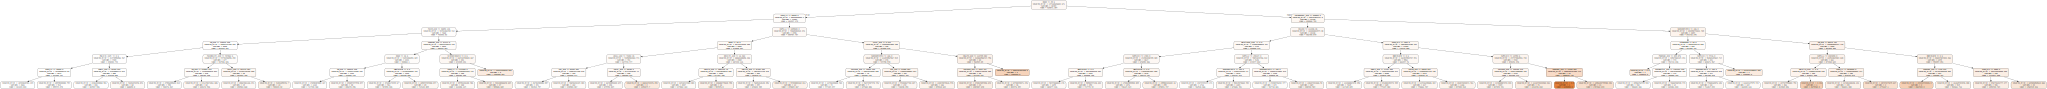

In [335]:
from graphviz import Source

Source.from_file("dot_files/tree_reg_2.dot")

Se grafica el archivo dot del árbol. 

In [336]:
Y_hat = tree_reg_2.predict(Xtest)

Predicción de $\hat{Y}$ a partir del segmento de prueba de $X$

In [337]:
MAE_2 = mean_absolute_error(Ytest, Y_hat)
MSE_2 =  mean_squared_error(Ytest, Y_hat)
RMSE_2 = math.sqrt(mean_squared_error(Ytest, Y_hat))
r2_2 = r2_score(Ytest, Y_hat)

In [338]:
print("MAE: %.2f" % MAE_2)
print("MSE: %.2f" % MSE_2)
print("RMSE: %.2f" % RMSE_2)
print('r2: %.2f' % r2_2)

MAE: 206266.49
MSE: 107263837889.14
RMSE: 327511.58
r2: 0.21


El error es más bajo que en el modelo anterior pero sige siendo demaciado alto considerando la renta media de al rededor de 625.000. El r2 esta vez es positivo, pero muy bajo.

In [339]:
import pickle

with open('models/tree_reg_2.pkl', 'wb') as file:
    pickle.dump(tree_reg_2, file)

Se guarda el modelo serializado.

#### **Modelo N°3**

Para este modelo se evaluará normalizar las variables independentes.

In [342]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

tree_reg_3 = Pipeline([
    ("Scaler", MinMaxScaler()),
    ("DecisionTree", DecisionTreeRegressor(random_state=123))
])

Se genera una tubería con normalización de datos y un árbol de decisión con los hiperparámetros por defecto.

In [343]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

param_distribs = {'DecisionTree__max_depth': np.arange(3,31),
                  'DecisionTree__min_samples_split': np.arange(2,30),
                  'DecisionTree__max_features':['sqrt', 'log2', 'auto'],
                  }
rnd_search_3 = HalvingRandomSearchCV(tree_reg_3, param_distributions=param_distribs, cv=6, random_state=321, return_train_score=True)
rnd_search_3.fit(Xtrain,Ytrain)

HalvingRandomSearchCV(cv=6,
                      estimator=Pipeline(steps=[('Scaler', MinMaxScaler()),
                                                ('DecisionTree',
                                                 DecisionTreeRegressor(random_state=123))]),
                      param_distributions={'DecisionTree__max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
                                           'DecisionTree__max_features': ['sqrt',
                                                                          'log2',
                                                                          'auto'],
                                           'DecisionTree__min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])},
                      random_state=321)

Se buscan los mejores hiperparámetros para el árbol de decisión, esta vez en un rango de busqueda máyor que en el modelo anterior. Luego se ajusta a los datos de entrenamiento

In [344]:
rnd_search_3.best_params_

{'DecisionTree__min_samples_split': 21,
 'DecisionTree__max_features': 'log2',
 'DecisionTree__max_depth': 4}

Mejores hiperparámetros obtenidos, esta vez el máximo de características es log2, el mínimo de ejemplares para dividir es mayor y el máximo de profundidad menor al modelo anterior.

In [345]:
tree_reg_3 = rnd_search_3.best_estimator_

Se guarda el modelo con los hiperparámetros de la mejor estimación.

In [347]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_reg_3[1],
        out_file="dot_files/tree_reg_3.dot",
        feature_names=[col for col in Xtrain.columns],
        filled=True,
        rounded=True
    )

Se genera un gráfico del árbo en formato dot.

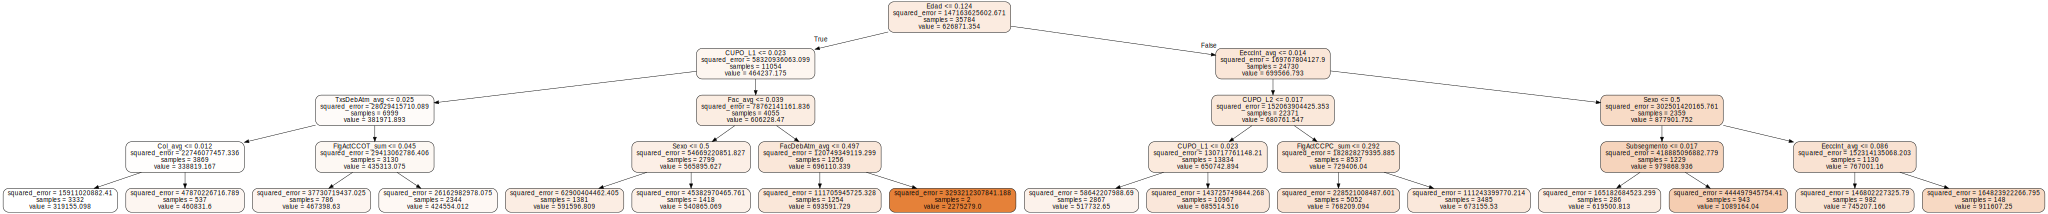

In [348]:
from graphviz import Source

Source.from_file("dot_files/tree_reg_3.dot")

Gráfico del árbol. Más pequeño que el árbol del modelo anterior.

In [349]:
Y_hat = tree_reg_3.predict(Xtest)

Predicción de $\hat{Y}$ a partir del segmento de prueba de $X$

In [350]:
MAE_3 = mean_absolute_error(Ytest, Y_hat)
MSE_3 =  mean_squared_error(Ytest, Y_hat)
RMSE_3 = math.sqrt(mean_squared_error(Ytest, Y_hat))
r2_3 = r2_score(Ytest, Y_hat)

In [351]:
print("MAE: %.2f" % MAE_3)
print("MSE: %.2f" % MSE_3)
print("RMSE: %.2f" % RMSE_3)
print('r2: %.2f' % r2_3)

MAE: 218441.61
MSE: 112556906518.92
RMSE: 335495.02
r2: 0.17


El modelo es un poco peor que el anterior, con un r2 ligeramente más bajo, lo mísmo se visualiza con la raíz del error cuadrático medio.

In [352]:
import pickle

with open('models/tree_reg_3.pkl', 'wb') as file:
    pickle.dump(tree_reg_3, file)

Se guarda el modelo serializado.

#### Comparacion de modelos

In [355]:
tabla = pd.DataFrame({'Métrica':['MAE:','MSE:','RMSE:','r2:'],
                      'Modelo 1':[MAE_1,MSE_1,RMSE_1,r2_1],
                      'Modelo 2':[MAE_2,MSE_2,RMSE_2,r2_2],
                      'Modelo 3':[MAE_3,MSE_3,RMSE_3,r2_3],})

# Obtener la fila 'RMSE:' y convertirla a números flotantes
fila_rmse = tabla.loc[2, tabla.columns != 'Métrica']
fila_rmse = fila_rmse.astype(float)

# Aplicar el formato a dos decimales a la fila 'RMSE:'
tabla.loc[2, tabla.columns != 'Métrica'] = fila_rmse.apply("{:.2f}".format)

# Tabla resultante
tabla

,Métrica,Modelo 1,Modelo 2,Modelo 3
0,MAE:,"250,366.60399","206,266.48908","218,441.61417"
1,MSE:,"176,210,622,083.52625","107,263,837,889.13625","112,556,906,518.92398"
2,RMSE:,419774.49,327511.58,335495.02
3,r2:,-0.30475,0.20577,0.16658


El modelo con mejor rendimiento es el modelo 2 que tiene mejor ajuste considerando el r2 y menor error en todas las métricas.

## Modelos de Clasificación

### Clasificacion SVM

#### Definición de variables

In [ ]:
# Carga de parquet preprocesado con GPU
path = 'monopoly_cleaned_parquet'
monopoly = cudf.read_parquet(path)

Se carga el modelo con la librería para GPU.

In [ ]:
from cudf.api.types import is_bool

#Transforma variables binarias tipo float en int
for col in monopoly.columns:
    if len(monopoly[col].unique()) == 2 and not is_bool(monopoly[col]):
        monopoly[col] = monopoly[col].astype(int)

Se transforman las variables binarias de tipo float a int para facilitar el procesamiento. 

In [ ]:
Y = monopoly['Internauta']
Y.head()

0    1
1    1
2    1
3    0
4    0
Name: Internauta, dtype: int64

Elegimos internauta como variable objetivo $Y$

In [ ]:
X = monopoly.drop(columns=['Internauta'])
X.head()

,Subsegmento,Sexo,Region,Edad,Renta,Antiguedad,Adicional,Dualidad,Monoproducto,Ctacte,Consumo,Hipotecario,Debito,CambioPin,Cuentas,TC,CUPO_L1,CUPO_L2,CUPO_MX,target,FlgAct_sum,FlgActCN_sum,FlgActCI_sum,FlgActAN_sum,FlgActAI_sum,FlgActPAT_sum,FlgActCCPC_sum,FlgActCCOT_sum,FlgActCOL_sum,Fac_avg,Txs_avg,FacCN_avg,TxsCN_avg,FacCI_avg,TxsCI_avg,FacAN_avg,TxsAN_avg,FacAI_avg,TxsAI_avg,FacPAT_avg,TxsPAT_avg,FacCCPC_avg,TxsCCPC_avg,FacCCOT_avg,TxsCCOT_avg,FacCOL_avg,TxsCOL_avg,FacDebCom_avg,TxsDebCom_avg,FacDebAtm_avg,TxsDebAtm_avg,Col_avg,ColL1T0_avg,ColL1TE_avg,ColL2T0_avg,ColL2AC_avg,ColL2CC_avg,ColMx_avg,PagoNac_avg,PagoInt_avg,EeccNac_avg,EeccInt_avg,UsoL1_avg,UsoL2_avg,UsoLI_avg
0,160.00000,1,13.00000,43.00000,"601,932.80000",130.00000,1,0,0,1,0,0,1,0,1.00000,3.00000,"798,000.00000","1,012,000.00000","1,210.00000",0,6.00000,6.00000,0.00000,0.00000,0.00000,0.00000,4.00000,1.00000,0.00000,"32,185.25000",1.91667,"32,185.25000",1.91667,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"15,511.25000",0.66667,"6,460.75000",0.25000,0.00000,0.00000,"178,764.16667",28.91667,"99,000.00000",4.25000,"920,109.33333","15,059.41667","842,900.75000","27,449.50000",0.00000,"34,699.66667",0.00000,"29,333.33333",0.00000,"908,079.41667",0.00000,"913,045.58333","53,874.25000",0.00000
1,160.00000,0,13.00000,46.00000,"143,640.00000",69.00000,0,0,0,1,0,1,0,0,1.00000,1.00000,"750,000.00000","150,000.00000","1,000.00000",0,11.00000,10.00000,2.00000,0.00000,0.00000,0.00000,9.00000,3.00000,0.00000,"112,918.44812",3.66667,"81,006.83333",2.58333,"31,911.61478",1.08333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"62,203.66667",1.58333,"8,916.66667",0.33333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"513,504.12917","7,469.83333","309,153.41667","133,584.41667",0.00000,"17,597.25000","45,699.21250","167,416.66667",0.00000,"460,136.50000",58.90417,"428,734.83333","119,963.91667",84.50833
2,170.00000,0,13.00000,45.00000,"929,106.00000",24.00000,1,0,0,1,0,1,1,1,1.00000,2.00000,"1,350,000.00000","200,000.00000","1,500.00000",0,12.00000,12.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"148,982.41667",5.00000,"140,434.33333",4.66667,"8,548.08333",0.33333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"118,568.66667",6.75000,"741,071.75000",15.00000,"117,984.83333","117,984.83333",0.00000,0.00000,0.00000,0.00000,0.00000,"68,325.75000",0.00000,"8,510.75000",0.00000,"25,294.50000",0.00000,0.00000
3,151.00000,0,13.00000,46.00000,"172,447.00000",134.00000,1,0,1,0,0,0,0,1,1.00000,2.00000,"1,570,800.00000","220,001.00000",0.00000,0,11.00000,11.00000,0.00000,0.00000,0.00000,0.00000,9.00000,1.00000,0.00000,"34,523.83333",2.08333,"34,523.83333",2.08333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"20,909.16667",1.16667,"1,082.50000",0.08333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"340,728.08333","14,826.16667","295,497.25000","27,698.16667",0.00000,"2,706.50000",0.00000,"57,083.33333",0.00000,"341,916.83333",0.00000,"344,417.50000","31,825.25000",0.00000
4,170.00000,0,13.00000,46.00000,"805,250.00000",116.00000,1,1,0,1,0,1,0,1,2.00000,3.00000,"2,762,000.00000",2.00000,"6,430.00000",0,12.00000,12.00000,0.00000,0.00000,0.00000,0.00000,12.00000,1.00000,0.00000,"293,939.00000",8.91667,"293,939.00000",8.91667,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"228,901.25000",4.33333,"3,916.66667",0.08333,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,"242,907.25000","51,661.25000",17.66667,"185,000.66667",0.00000,"6,227.66667",0.00000,"291,317.16667",0.00000,"291,684.50000",0.00000,"83,849.25000","402,597.66667",0.00000


Utilizamos el resto de variables como $X$

In [ ]:
from cuml.model_selection import train_test_split

# division en segmentos de entrenamiento y prueba
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X ,Y,test_size=0.3, random_state=455)
Ytest_pd = Ytest.to_pandas()

División de $X$ e $Y$ en segmentos de prueba y entrenamiento con una proporción de 3:7 respectivamente.

#### Modelo N°1 

In [ ]:
from cuml.svm import SVC
svc_1 = SVC(class_weight='balanced', output_type='pandas', random_state=123)

Se genera un modelo de Suport vector machine para clasificación, debido al desbalance de las clases, se utiliza el hiperparámetro class_weight con el valor "balanced" que le da un peso a las clases a pertir de su frecuecia en los datos de entrenamiento.

In [ ]:
from cuml.model_selection import train_test_split

svc_1.fit(Xtrain, Ytrain)

SVC()

Se ajusta el modelo a los datos de entrenamiento.

In [ ]:
# predicciond de Y hat
Y_hat = svc_1.predict(Xtest)

Predicción de $\hat{Y}$ a partir del segmento de prueba de $X$

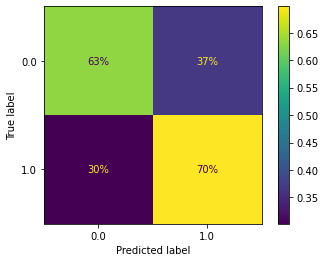

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Matriz de Confusion
matriz = confusion_matrix(Ytest_pd, Y_hat)
ConfusionMatrixDisplay.from_predictions(Ytest_pd, Y_hat, display_labels=svc_1.classes_, normalize='true', values_format='.0%')

Se utiliza una matriz de confusión en porcentajes para facilitar la interpretación de los datos desbalanceados. 
A partir de la matiz identificamos un recall de 63%, sensibilidad de 70%, error de tipo I de 37% y error de tipo II de 30%. Por lo que el modelo tiende a clasificar correctamente los elementos de la clase postiva un 70% de las veces y de la clase negativa un 63% de las veces.

In [ ]:
VN, FP, FN, VP = matriz.ravel()
print(f'Verdaderos positivos (VP): {VP}')
print(f'Falsos positivos (FP): {FP}')
print(f'Verdaderos negativos (VN): {VN}')
print(f'Falsos negativos (FN): {FN}')

Verdaderos positivos (VP): 7325
Falsos positivos (FP): 1784
Verdaderos negativos (VN): 3060
Falsos negativos (FN): 3167


In [ ]:
from sklearn.metrics import classification_report
#Metricas
print(classification_report(Ytest_pd, Y_hat))

              precision    recall  f1-score   support

           0       0.49      0.63      0.55      4844
           1       0.80      0.70      0.75     10492

    accuracy                           0.68     15336
   macro avg       0.65      0.66      0.65     15336
weighted avg       0.71      0.68      0.69     15336



Se repite parte de la información que habiamos obtenido con la matriz de confusión, pero obtemos información sobre el f1-score para cada clase, del que podemos rescatar que el modelo clasifica de mejor manera la clase positiva que la negativa.

In [ ]:
from sklearn.metrics import f1_score
#F1-Score
f1_svc_1 = f1_score(Ytest.to_pandas(), Y_hat)
score_svc_1 = svc_1.score(Xtest.to_pandas(), Ytest.to_pandas())
#Tasa de error
tfp_svc_1 = FP/(FP+VN)
tfn_svc_1 = FN/(FN+VP)

print("Error tipo I: %.2f" % tfp_svc_1  )
print("Error tipo II: %.2f" % tfn_svc_1  )
print("Accuracy: %.2f" % score_svc_1)
print("F1-Score: %.2f" % f1_svc_1 )

Error tipo I: 0.37
Error tipo II: 0.30
Accuracy: 0.68
F1-Score: 0.75


Obtenemos un F1-score de 0.75 y un accuracy de 0.68. Por lo que las estimaciones del modelo coinciden con el valor real de los datos en un 68%. 

In [ ]:
import pickle

with open('models/svc_1.pkl', 'wb') as file:
    pickle.dump(svc_1, file)

Se guarda el modelo serializado

#### Modelo N°2

In [ ]:
# se calcula el valor de gamma por defecto al usar hiperparametro gamma='scale'
n_features = X.shape[1]
default_gamma = 1 / (n_features * X.to_numpy().var())
print(default_gamma)

2.246110277749219e-13


In [ ]:
from cuml.svm import SVC
svc_2 = SVC(class_weight='balanced', gamma='auto', output_type='pandas', random_state=123) # se aumenta el valor de gamma

Se aumenta el valor de gamma cambiando el valor a "auto". El valor por defecto de gamma es 1/n_features*X.var() y el valor de "auto" es 1/n_features. 
Por lo que en el modelo anterior teniamos $y=2.2 * 10^{-13}$ y en modelo acutal $y=0.015$. 

In [ ]:
svc_2.fit(Xtrain, Ytrain)

SVC()

Se ajusta el modelo a las variables de entrenamiento

In [ ]:
# predicciond de Y hat
Y_hat = svc_2.predict(Xtest)

Predicción de $\hat{Y}$ a partir del segmento de prueba de $X$

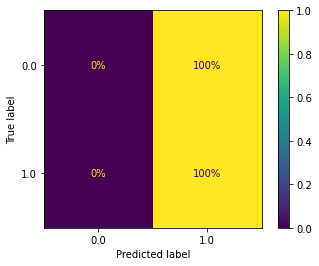

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Matriz de Confusion
matriz = confusion_matrix(Ytest_pd, Y_hat)
ConfusionMatrixDisplay.from_predictions(Ytest_pd, Y_hat, display_labels=svc_2.classes_, normalize='true', values_format='.0%')

Tenemos un error de tipo I de 100%, sensibilidad de 100%, recall y error de tipo II de 0%, en resumen el modelo clasifica todo como parte de la clase positiva.

In [ ]:
VN, FP, FN, VP = matriz.ravel()
print(f'Verdaderos positivos (VP): {VP}')
print(f'Falsos positivos (FP): {FP}')
print(f'Verdaderos negativos (VN): {VN}')
print(f'Falsos negativos (FN): {FN}')

Verdaderos positivos (VP): 10492
Falsos positivos (FP): 4844
Verdaderos negativos (VN): 0
Falsos negativos (FN): 0


In [ ]:
from sklearn.metrics import classification_report
#Metricas
print(classification_report(Ytest_pd, Y_hat))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4844
           1       0.68      1.00      0.81     10492

    accuracy                           0.68     15336
   macro avg       0.34      0.50      0.41     15336
weighted avg       0.47      0.68      0.56     15336



In [ ]:
#F1-Score
f1_svc_2 = f1_score(Ytest.to_pandas(), Y_hat)
score_svc_2 = svc_2.score(Xtest.to_pandas(), Ytest.to_pandas())
#Tasa de error
tfp_svc_2 = FP/(FP+VN)
tfn_svc_2 = FN/(FN+VP)

print("Error tipo I: %.2f" % tfp_svc_2  )
print("Error tipo II: %.2f" % tfn_svc_2  )
print("Accuracy: %.2f" % score_svc_2)
print("F1-Score: %.2f" % f1_svc_2 )

Error tipo I: 1.00
Error tipo II: 0.00
Accuracy: 0.68
F1-Score: 0.81


El F1-score es mayor al modelo anterior, pero el modelo es menos útil ya que clasifica todo en la misma clase.

In [ ]:
import pickle

with open('models/svc_2.pkl', 'wb') as file:
    pickle.dump(svc_2, file)

Se almacena el modelo serializado.

#### Modelo N°3

In [ ]:
# se calcula el valor de gamma por defecto al usar hiperparametro gamma='scale'
n_features = X.shape[1]
default_gamma = 1 / (n_features * X.to_numpy().var())
new_gamma = default_gamma*3

Se calcula el valor por defecto de gamma y se multiplica por 3 para aumentar el ajuste del modelo. 

In [ ]:
from cuml.svm import SVC
svc_3 = SVC(class_weight='balanced', gamma=new_gamma, C=5, output_type='pandas', random_state=123) # disminuimos gamma respecto al modelo 2 y aumentamos respecto al 3 y aumentamos C

Se aumenta el valor de C a demás del de $y$ (gamma), para aumentar el ajuste del modelo.

In [ ]:
svc_3.fit(Xtrain, Ytrain)

SVC()

Se ajusta el modelo a los datos de entrenamiento.

In [ ]:
# predicciond de Y hat
Y_hat = svc_3.predict(Xtest)

Predicción de $\hat{Y}$ a partir del segmento de prueba de $X$

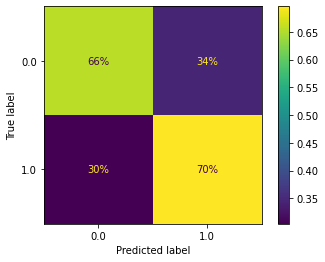

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Matriz de Confusion
matriz = confusion_matrix(Ytest_pd, Y_hat)
ConfusionMatrixDisplay.from_predictions(Ytest_pd, Y_hat, display_labels=svc_3.classes_, normalize='true', values_format='.0%')

Obtenemos resultados ligeramente mejores que en el modelo 1. La sensibilidad y el error de tipo II es el mismo, pero aumenta el recall y por lo tanto también disminulle en el error de tipo I

In [ ]:
VN, FP, FN, VP = matriz.ravel()
print(f'Verdaderos positivos (VP): {VP}')
print(f'Falsos positivos (FP): {FP}')
print(f'Verdaderos negativos (VN): {VN}')
print(f'Falsos negativos (FN): {FN}')

Verdaderos positivos (VP): 7304
Falsos positivos (FP): 1669
Verdaderos negativos (VN): 3175
Falsos negativos (FN): 3188


In [ ]:
from sklearn.metrics import classification_report
#Metricas
print(classification_report(Ytest_pd, Y_hat))

              precision    recall  f1-score   support

           0       0.50      0.66      0.57      4844
           1       0.81      0.70      0.75     10492

    accuracy                           0.68     15336
   macro avg       0.66      0.68      0.66     15336
weighted avg       0.71      0.68      0.69     15336



In [ ]:
#F1-Score
f1_svc_3 = f1_score(Ytest.to_pandas(), Y_hat)
score_svc_3 = svc_3.score(Xtest.to_pandas(), Ytest.to_pandas())
#Tasa de error
tfp_svc_3 = FP/(FP+VN)
tfn_svc_3 = FN/(FN+VP)

print("Error tipo I: %.2f" % tfp_svc_3  )
print("Error tipo II: %.2f" % tfn_svc_3  )
print("Accuracy: %.2f" % score_svc_3)
print("F1-Score: %.2f" % f1_svc_3 )

Error tipo I: 0.34
Error tipo II: 0.30
Accuracy: 0.68
F1-Score: 0.75


El F1-Score se mantiene igual que en el modelo 1, probablemente porque los valores estén redondeados, ya que los resultados son ligeramente mejores al mantener el nivel de sensibilidad y aumetar el recall.

In [ ]:
import pickle

with open('models/svc_3.pkl', 'wb') as file:
    pickle.dump(svc_3, file)

Se guarda el modelo serializado

#### Modelo N°4

In [ ]:
from sklearn.svm import SVC
svc_4 = SVC(random_state=123)

Se genera un SVM con hiperparámetros por defecto.

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

param_distribs = {
    'class_weight':['balanced'],
    'C': (0.1, 20.0, 'log-uniform'),  # Rango logarítmico para C
    'gamma': (default_gamma, default_gamma*20, 'log-uniform'),  # Rango logarítmico para gamma
    'kernel': ['linear', 'rbf'],  # Kernel lineal y RBF
}
rnd_search = HalvingRandomSearchCV(svc_4, param_distributions=param_distribs, cv=5, random_state=123, return_train_score=True, n_jobs=-1).fit(Xtrain.to_pandas(), Ytrain.to_pandas())

Se buscan los mejores hiperparámetro con HalvingRandomSearchCV y se ajusta el resultado a los datos de entrenamiento

In [ ]:
rnd_search.best_params_

{'kernel': 'rbf',
 'gamma': 4.492220555498438e-12,
 'class_weight': 'balanced',
 'C': 20.0}

Resultados de la busquda

In [ ]:
svc_4 = rnd_search.best_estimator_

Se genera un modelo con los mejores hiperparámetros y se ajusta a los datos de entrenamiento

In [ ]:
# predicciond de Y hat
Y_hat = svc_4.predict(Xtest.to_pandas())

Predicción de $\hat{Y}$ a partir del segmento de prueba de $X$

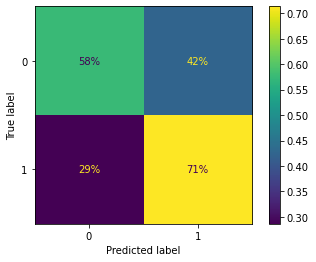

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#Matriz de Confusion
matriz = confusion_matrix(Ytest_pd, Y_hat)
ConfusionMatrixDisplay.from_predictions(Ytest_pd, Y_hat, display_labels=svc_4.classes_, normalize='true', values_format='.0%')

In [ ]:
VN, FP, FN, VP = matriz.ravel()
print(f'Verdaderos positivos (VP): {VP}')
print(f'Falsos positivos (FP): {FP}')
print(f'Verdaderos negativos (VN): {VN}')
print(f'Falsos negativos (FN): {FN}')

Verdaderos positivos (VP): 7488
Falsos positivos (FP): 2054
Verdaderos negativos (VN): 2790
Falsos negativos (FN): 3004


In [ ]:
from sklearn.metrics import classification_report
#Metricas
print(classification_report(Ytest_pd, Y_hat))

              precision    recall  f1-score   support

           0       0.48      0.58      0.52      4844
           1       0.78      0.71      0.75     10492

    accuracy                           0.67     15336
   macro avg       0.63      0.64      0.64     15336
weighted avg       0.69      0.67      0.68     15336



In [ ]:
from sklearn.metrics import f1_score
#F1-Score
f1_svc_4 = f1_score(Ytest.to_pandas(), Y_hat)
score_svc_4 = svc_4.score(Xtest.to_pandas(), Ytest.to_pandas())
#Tasa de error
tfp_svc_4 = FP/(FP+VN)
tfn_svc_4 = FN/(FN+VP)

print("Error tipo I: %.2f" % tfp_svc_4  )
print("Error tipo II: %.2f" % tfn_svc_4  )
print("Accuracy: %.2f" % score_svc_4)
print("F1-Score: %.2f" % f1_svc_4 )

Error tipo I: 0.42
Error tipo II: 0.29
Accuracy: 0.67
F1-Score: 0.75


Se logra un rendimiento muy similar a los modelos 1 y 3, pero presenta un peor rendimiento clasificando correctamente los elementos de la clase negativa y mejor rendimiento en los elementos de la clase positiva respecto a los modelos 1 y 3.

In [ ]:
import pickle

with open('models/svc_4.pkl', 'wb') as file:
    pickle.dump(svc_4, file)

Se guarda el modelo serializado

#### Comparacion de modelos

In [ ]:
tabla = pd.DataFrame({'Métrica':['Error Tipo I:','Error Tipo II:','Accuracy:','F1-Score'],
                      'Modelo 1':[tfp_svc_1,tfn_svc_1,score_svc_1,f1_svc_1],
                      'Modelo 2':[tfp_svc_2,tfn_svc_2,score_svc_2,f1_svc_2],
                      'Modelo 3':[tfp_svc_3,tfn_svc_3,score_svc_3,f1_svc_3],
                      'Modelo 4':[tfp_svc_4,tfn_svc_4,score_svc_4,f1_svc_4],
                    })

# Tabla resultante
tabla

,Métrica,Modelo 1,Modelo 2,Modelo 3,Modelo 4
0,Error Tipo I:,0.36829,1.00000,0.34455,0.42403
1,Error Tipo II:,0.30185,0.00000,0.30385,0.28631
2,Accuracy:,0.67716,0.68414,0.68329,0.67019
3,F1-Score,0.74741,0.81245,0.75048,0.74753


**El mejor modelo es el modelo 3** ya que tiene mejor F1-score que los modelos 1 y 4, al mismo los errores de tipo I y II están más equilibrados que en el modelo 2, el cual tiene 100% de error tipo I y 0% de error tipo II.